### Import Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical   
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### MNIST Dataset Load


*   For the dataset-loading, keras is used
*   Asuming the dataset is gaussian-distributed, data are standardized (shifted to zero mean followed by the scalling to unity standard deviation). 

*   To match the dimension of CIFER-10 sample, MNIST samples (28x28) are zero-padded and reshaped to the size of CIFER-10 image (32x32) 
*  3 identical grayscale channels for MNIST data are created to make the model learned from MNIST dataset compatiable with the CIFER-10 dataset of RGB channel. 







In [ ]:
# MNIST Dataset
(x_train1, y_train1), (x_test1, y_test1) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

# Dataset Standardization
mean_MNIST = np.mean(x_train1)
std_MNIST = np.std(x_train1)
x_train2 = (x_train1-mean_MNIST)/(std_MNIST+1e-7)
x_test2 = (x_test1-mean_MNIST)/(std_MNIST+1e-7)

# Image reshaping and normalizing with CIFAR10
x_train=np.zeros((x_train2.shape[0],32,32,3), dtype=np.float16)
x_test=np.zeros((x_test2.shape[0],32,32,3), dtype=np.float16)
for i in range(x_train2.shape[0]):
    x_train[i,2:30,2:30,0]=x_train2[i]/255
    x_train[i,2:30,2:30,1]=x_train2[i]/255
    x_train[i,2:30,2:30,2]=x_train2[i]/255
for i in range(x_test2.shape[0]):
    x_test[i,2:30,2:30,0]=x_test2[i]/255
    x_test[i,2:30,2:30,1]=x_test2[i]/255
    x_test[i,2:30,2:30,2]=x_test2[i]/255
    
# # Expanding Dimensions
# x_train=np.zeros((32,32,3), dtype=np.float16)
# x_test=np.zeros((32,32,3), dtype=np.float16)

# x_train=np.expand_dims(x_train3,axis=-1)
# x_test=np.expand_dims(x_test3,axis=-1)

input_shape=(x_train.shape[1], x_train.shape[2], 3)

11493376/11490434 [==============================] - 0s 0us/step


### Training Data Plotting
First 30 images from MNIST training dataset are plotted and the integer labels are converted to one hot encoded labels.

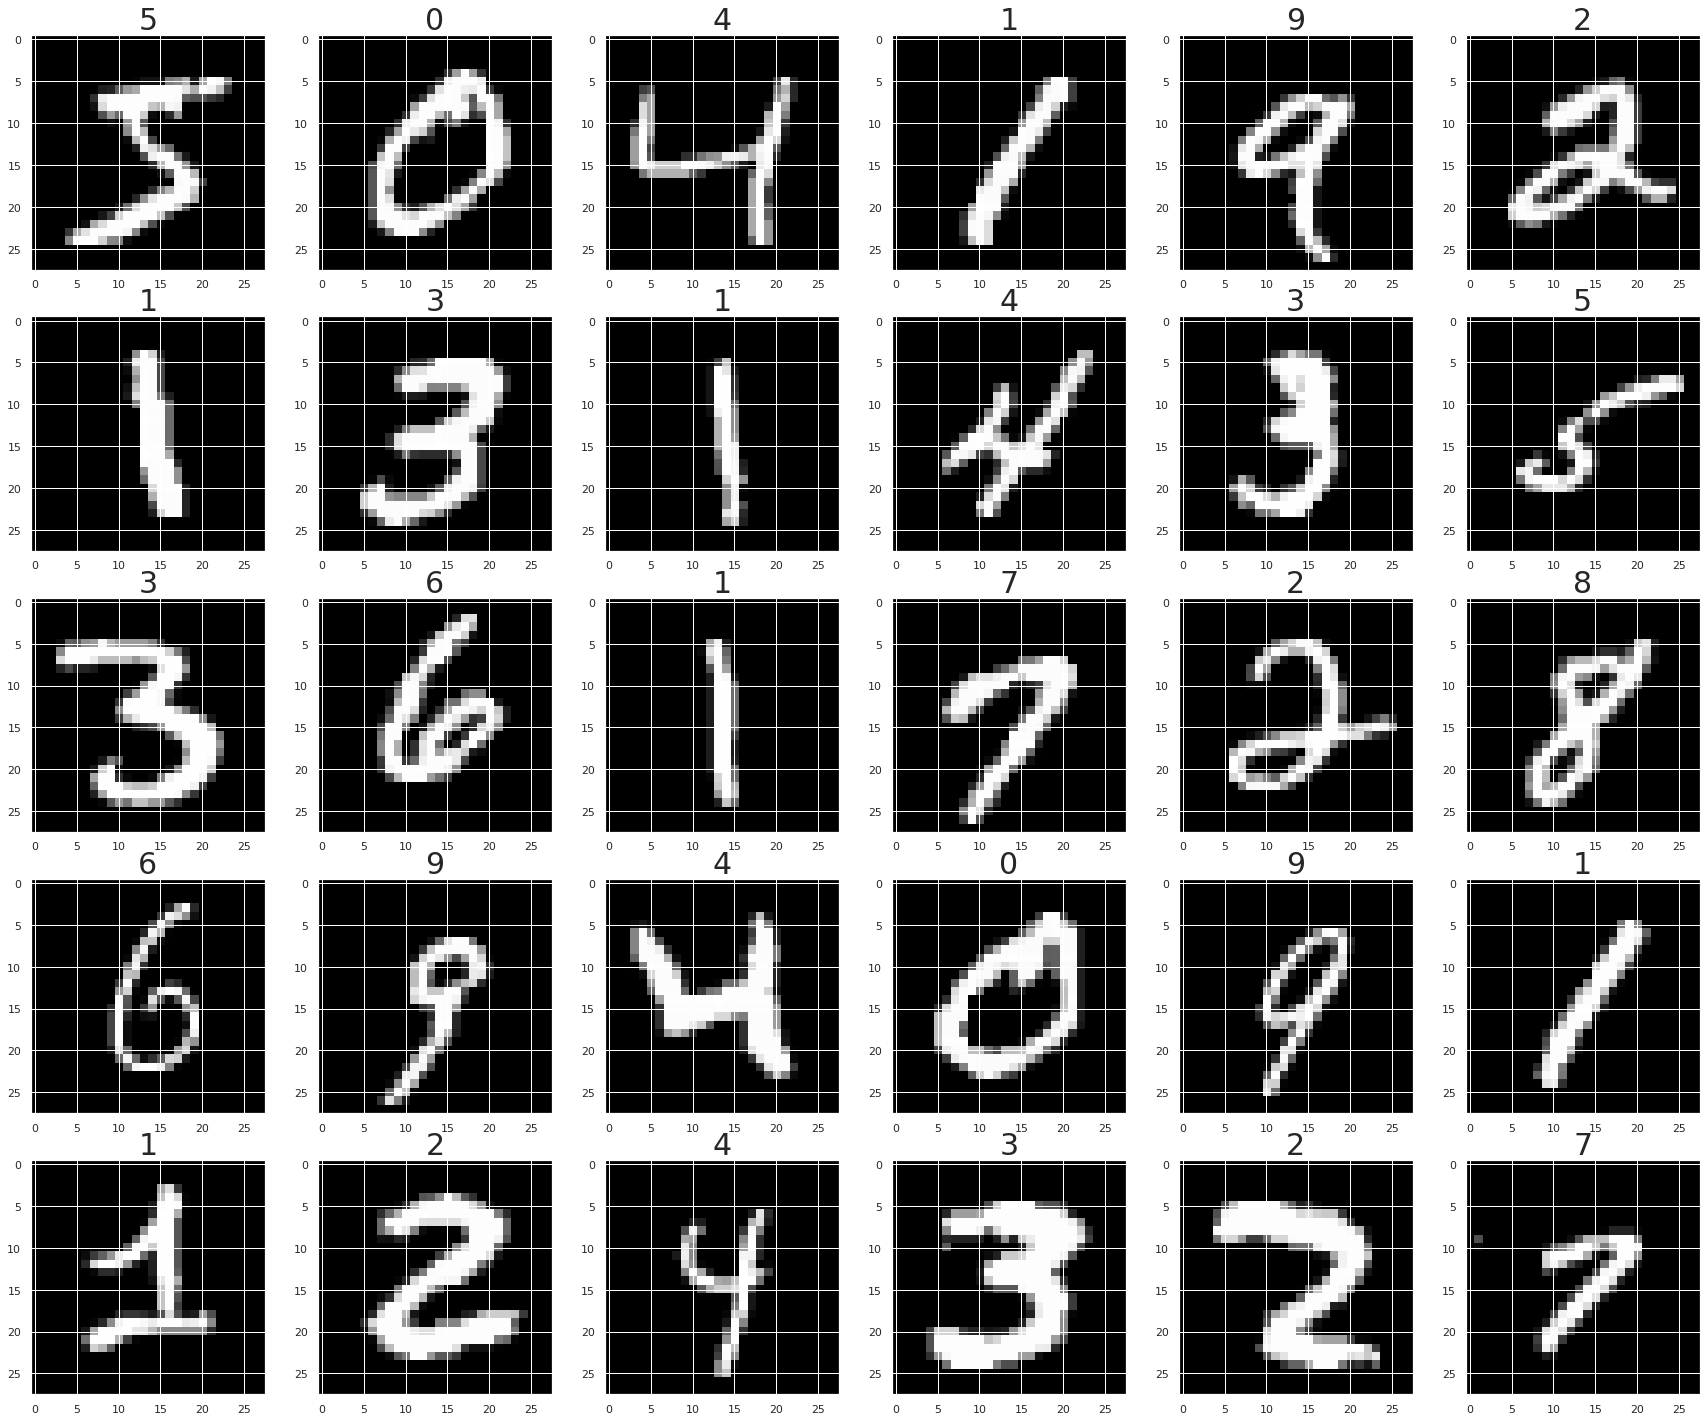

In [ ]:
# Parameters
EPOCHS=20
BATCH_SIZE=128

# Class Labels
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# One hot encoding
y_train=to_categorical(y_train1, num_classes=10)
y_test=to_categorical(y_test1, num_classes=10)

# Plotting Training Data
plt.subplots(5,6,figsize=(30,25))
for k in range(30):
    plt.subplot(5,6,k+1)
    plt.imshow(x_train1[k], cmap = plt.cm.gray, interpolation='nearest', clim=(0, 255))
    plt.title(class_names[y_train1[k]],fontsize=30)

### Network Architecture

The Network used for this project is a VGG based network which has 

*   2D convolutional layers with (3x3) kernel
*   2D max-pooling layers with (2x2) kernel
*   Fully connected layers
*   Dropout layers

Each of the layers are activated by ReLU or Sigmoid after operation. ADAM or SGD is used as Optimizers. An exponentially decaying learning rate is used with a decay factor of 0.96. To avoid overfitting for any neurons, heavy dropouts and L1 regularizer is used to optimize the layers. Batch normalization is used after each layers. Final Fully connected layer with 10 neurons is activated by softmax to have an individual probabibility distribution for the classes.

In [ ]:
def create_model(ilr, optimizer, input_shape, act):
    weight_decay = 0.0005
    model = tf.keras.models.Sequential([
        keras.layers.Conv2D(64,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(64,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(128,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(128,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(256,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(256,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(256,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax'),
        ])
    
    model.summary()
    
    # Learning Rates
    initial_learning_rate = ilr
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_rate=0.98,
        decay_steps=EPOCHS,
        staircase=True)
        
    #optimization details
    if optimizer=='adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9,),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model

### Data Augmentation

Data is augmented using 

*   15 degree rotation
*   width and height shifting by around 4 pixel randomly
*  flipping the images horizontally



In [50]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

### Problem 1.b: (ADAM)

For Adam optimizer, optimum learning rate is found to be 0.01 as initial value.

In [ ]:
#%% Model train MNIST_ADAM_relu
filepath='MNIST_ADAM_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=False, mode='max')
callbacks_list = [checkpoint]
model = create_model(0.01, 'adam', input_shape, 'relu')
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test),
          callbacks=callbacks_list, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)      

Loss and Accuracy against Epoch is plotted for Adam optimizer

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


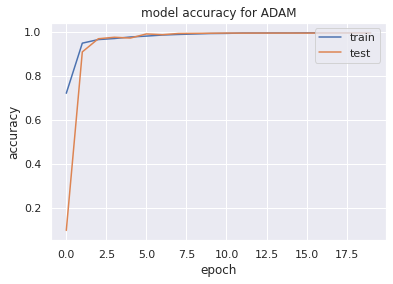

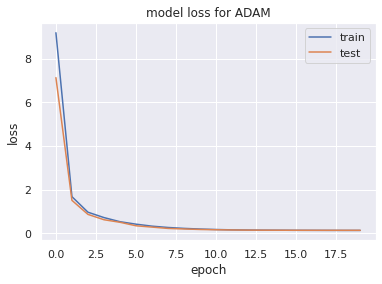

In [ ]:
print(history_ADAM.history.keys())
# summarize history for accuracy
plt.figure(1)
plt.plot(history_ADAM.history['accuracy'])
plt.plot(history_ADAM.history['val_accuracy'])
plt.title('model accuracy for ADAM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.figure(2)
plt.plot(history_ADAM.history['loss'])
plt.plot(history_ADAM.history['val_loss'])
plt.title('model loss for ADAM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Problem 1.b: (SGD)
For SGD optimizer, optimum learning rate is considered to be 0.1 as initial value.

In [ ]:
#%% Model train MNIST_SGD_relu
filepath='MNIST_SGD_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=False, mode='max')
callbacks_list = [checkpoint]
model = create_model(0.1, 'sgd', input_shape, 'relu')
history_SGD = model.fit(x_train, y_train, batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test),
          callbacks=callbacks_list, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 128)      

Loss and Accuracy against Epoch is plotted for SGD optimizer

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


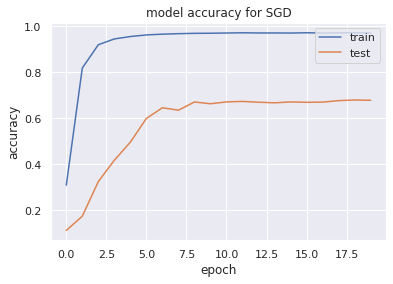

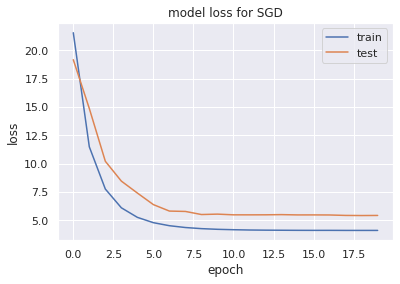

In [ ]:
print(history_SGD.history.keys())
# summarize history for accuracy
plt.figure(1)
plt.plot(history_SGD.history['accuracy'])
plt.plot(history_SGD.history['val_accuracy'])
plt.title('model accuracy for SGD')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.figure(2)
plt.plot(history_SGD.history['loss'])
plt.plot(history_SGD.history['val_loss'])
plt.title('model loss for SGD')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Problem 1.c:

From this experiment, we can see that SGD optimizer takes much longer time to converge than the Adam optimizer, but it is approaching to a global minima with the increament of epochs.

### Problem 2.b: (Sigmoid)

The network is trained with Sigmoid activation with same learning rate of the network trained with ReLU.

In [ ]:
#%% Model train MNIST_ADAM_Sigmoid
filepath='MNIST_SIGMOID_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=False, mode='max')
callbacks_list = [checkpoint]
model = create_model(0.01, 'adam', input_shape, 'sigmoid')
history_sigmoid = model.fit(x_train, y_train, batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test),
          callbacks=callbacks_list, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_40 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 128)      

Loss and Accuracy against Epoch is plotted for Sigmoid activation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


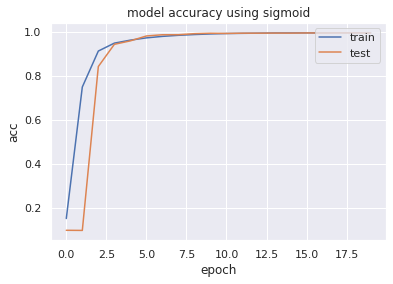

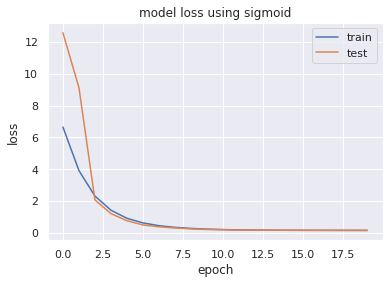

In [ ]:
print(history_sigmoid.history.keys())
# summarize history for accuracy
plt.figure(1)
plt.plot(history_sigmoid.history['accuracy'])
plt.plot(history_sigmoid.history['val_accuracy'])
plt.title('model accuracy using sigmoid')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.figure(2)
plt.plot(history_sigmoid.history['loss'])
plt.plot(history_sigmoid.history['val_loss'])
plt.title('model loss using sigmoid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Problem 2.c:

Here we can see that the the network with Sigmoid activation has much slower convergence and more oscillation than the network trained with ReLU activation (Problem 1.b)

### Problem 3.b: (early stopping)
The network trained in the previous problem with Sigmoid activation and Adam optimizer was not early stopped and weights after every epoch were saved. Now another model is trained with the early stopping and saving only the best possible weight from the validation set.

In [ ]:
#%% Model train MNIST_ADAM_Sigmoid
filepath='best_weight_MNIST_SIGMOID.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True)
callbacks_list = [checkpoint]
model = create_model(0.01, 'adam', input_shape, 'sigmoid')
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test),
          callbacks=callbacks_list, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_70 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_50 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_71 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 128)      

### Problem 3.c: (Early stopping comparison)
### Problem 3.c: 

If we compare the two models, one with early stopping (saving the best weight) and the other without early stopping (saving weights from each epoch), we can see that the accuracy (99.39%) is same for both the stretegy.  

In [ ]:
#%% Model test
tf.keras.backend.clear_session()
model_test_b = create_model(0.01, 'adam', input_shape, 'sigmoid')
checkpoint_path='best_weight_MNIST_SIGMOID.hdf5'
model_test_b.load_weights(checkpoint_path)
loss_b,acc_b = model_test_b.evaluate(x_test,  y_test, batch_size=BATCH_SIZE, verbose=1)

tf.keras.backend.clear_session()
model_test_f = create_model(0.01, 'adam', input_shape, 'sigmoid')
checkpoint_path='MNIST_SIGMOID_weights.hdf5'
model_test_f.load_weights(checkpoint_path)
loss_f,acc_f = model_test_f.evaluate(x_test,  y_test, batch_size=BATCH_SIZE, verbose=1)

print("\nEarly Stopped (Best) Model accuracy: {:5.2f}%".format(100*acc_b))
print("\nFinal Epoch Model accuracy: {:5.2f}%".format(100*acc_f))
#ypred=np.argmax(model_test.predict(x_test, batch_size=BATCH_SIZE),axis=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

### Problem 4.b: (augmentation)
The previous networks we used all the data with no augmentation. So now we train a network with data augmentation.

In [ ]:
#%% Model train MNIST_ADAM_relu_no_augmentation
filepath='best_weight_MNIST_RELU_noaug.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model = create_model(0.01, 'adam', input_shape, 'relu')
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)      

### Problem 4.c: 


*   Accuracy with augmentation: 99.34%
*   Accuracy without augmentation: 99.39%

There is no noticeable difference between the accuracies. Because, data augmentation in MNIST dataset has no significant meaning in real test image space and hence no improvement in accuracy.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


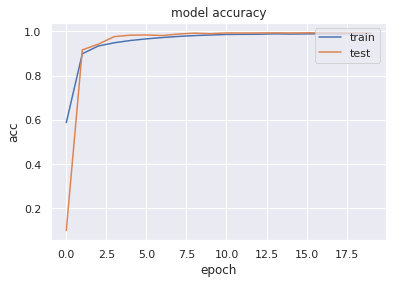

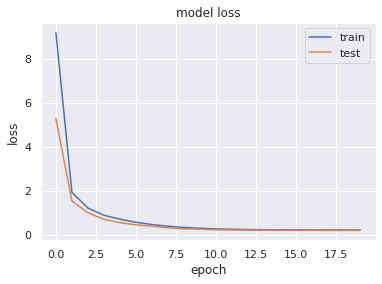

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Problem 5.a:

A new network is declared with less layers than the previous one. Reducing the number of convolutional layers, the number of filters are increased. But both have the similar number of parameters (~15M. The trainable and non-trainable parameters are also similar.

In [ ]:
def create_model_v2(ilr, optimizer, input_shape, act):
    weight_decay = 0.0005
    model = tf.keras.models.Sequential([
        keras.layers.Conv2D(128,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(192,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(192,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(256,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512,(3,3),input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, kernel_regularizer=keras.regularizers.l2(weight_decay), activation=act),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax'),
        ])
    
    model.summary()
    
    # Learning Rates
    initial_learning_rate = ilr
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_rate=0.98,
        decay_steps=EPOCHS,
        staircase=True)
        
    #optimization details
    if optimizer=='adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9,),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model

### Problem 5.b:
Now, model is trained with the recent declared network

In [ ]:
#%% Model train MNIST_different layers
tf.keras.backend.clear_session()
filepath='MNIST_ADAM_weights_model2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model1 = create_model(0.01, 'adam', input_shape, 'relu')
model2 = create_model_v2(0.01, 'adam', input_shape, 'relu')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7



*   accuracy from model with reduced layers: 99.7%
*   accuracy from model with deep layers: 99.34%

Which means that increment of filters is more effective than deep layers.

In [ ]:
# Model2_MNIST_ADAM_relu_noaug
history = model2.fit(x_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list, verbose=1)

Epoch 1/20
469/469 [==============================] - 59s 121ms/step - loss: 13.9437 - accuracy: 0.7118 - val_loss: 11.3966 - val_accuracy: 0.1135

Epoch 00001: val_accuracy improved from -inf to 0.11350, saving model to MNIST_ADAM_weights_model2.hdf5
Epoch 2/20
469/469 [==============================] - 56s 119ms/step - loss: 1.6195 - accuracy: 0.9481 - val_loss: 1.0935 - val_accuracy: 0.9298

Epoch 00002: val_accuracy improved from 0.11350 to 0.92980, saving model to MNIST_ADAM_weights_model2.hdf5
Epoch 3/20
469/469 [==============================] - 56s 119ms/step - loss: 0.8636 - accuracy: 0.9636 - val_loss: 0.7756 - val_accuracy: 0.9360

Epoch 00003: val_accuracy improved from 0.92980 to 0.93600, saving model to MNIST_ADAM_weights_model2.hdf5
Epoch 4/20
469/469 [==============================] - 56s 119ms/step - loss: 0.6246 - accuracy: 0.9717 - val_loss: 0.5305 - val_accuracy: 0.9686

Epoch 00004: val_accuracy improved from 0.93600 to 0.96860, saving model to MNIST_ADAM_weights_m

### CIFAR10 Dataset Load


*   dataset loading with keras

*   Standardization is done same as for MNIST

First 30 images of the training dataset are plotted with corresponding class labels as title..

(10000, 32, 32, 3)


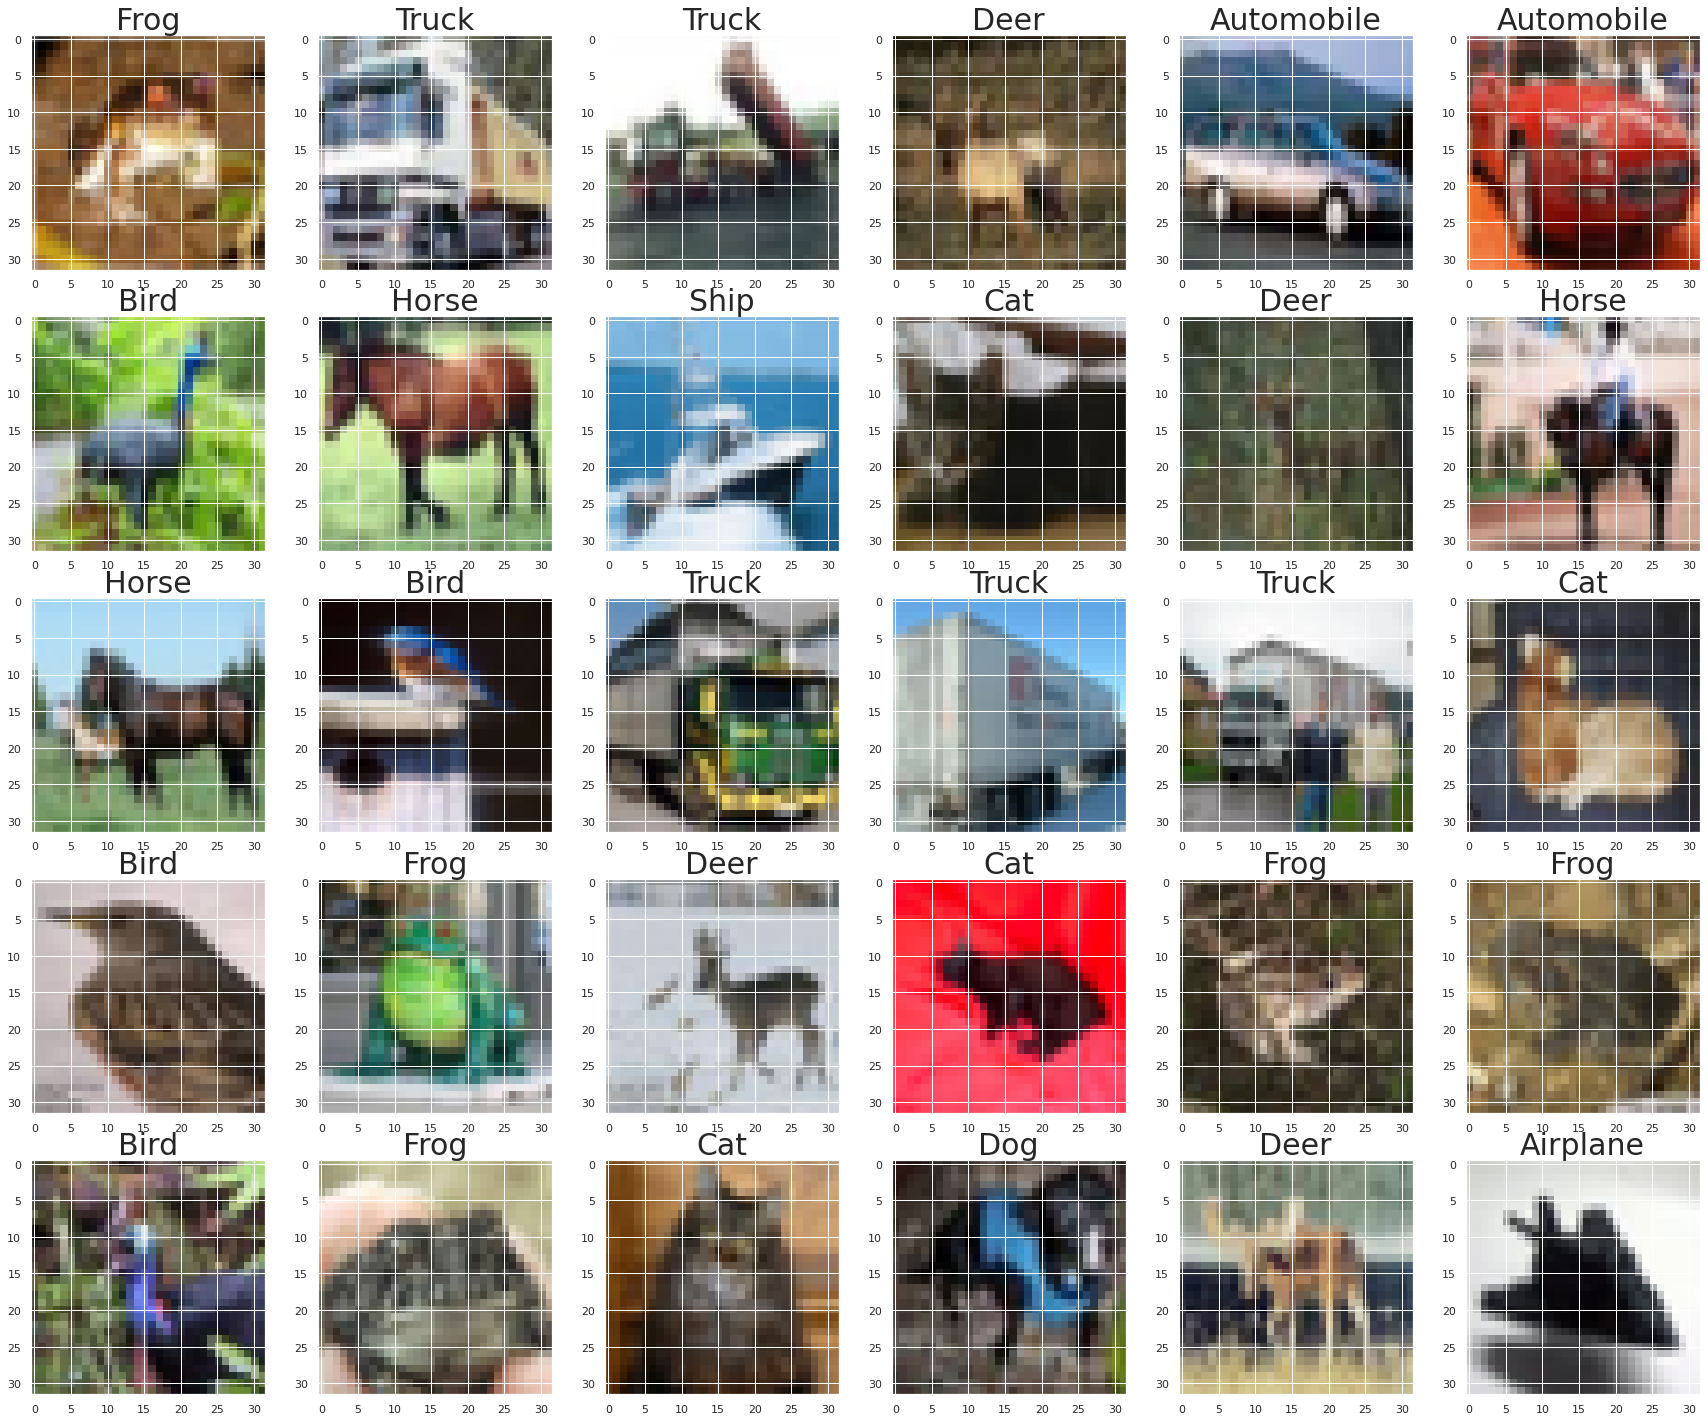

In [46]:
# CIFAR10 dataset
(x_train1, y_train1), (x_test1, y_test1) = tf.keras.datasets.cifar10.load_data()
mean = np.mean(x_train1)
std = np.std(x_train1)
x_train = (x_train1-mean)/(std+1e-7)
x_test = (x_test1-mean)/(std+1e-7)
input_shape=(x_train.shape[1], x_train.shape[2], 3)

# Parameters
EPOCHS=149
BATCH_SIZE=128

# Class Labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# One hot encoding
y_train=to_categorical(y_train1, num_classes=10)
y_test=to_categorical(y_test1, num_classes=10)

# Plotting Training Data
plt.subplots(5,6,figsize=(30,25))
for k in range(30):
    plt.subplot(5,6,k+1)
    plt.imshow(x_train1[k], cmap = plt.cm.gray, interpolation='nearest', clim=(0, 255))
    plt.title(class_names[y_train1[k][0]],fontsize=30)

print(x_test.shape)

### Weight Loaded from the MNIST model and check for accuracy of the CIFAR10 test Dataset

In [ ]:
#%% Model test
tf.keras.backend.clear_session()
model = create_model(0.001, 'adam', input_shape, 'relu')
checkpoint_path='MNIST_ADAM_weights.hdf5'
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(x_test,  y_test, batch_size=BATCH_SIZE, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

We can see that the CIFAR10 test dataset accuracy is only 9.4% with the weight loaded from the trained model on MNIST dataset. This is intuitive because of the differences in image types.

### Transfer Learning

To re-train the model for CIFAR10 dataset, transfer learning is used. Here, I considered only the weights of the first two convolutional layers which are obtained from the MNIST dataset training. Generally, first convolutional layer  captures edges and corners which are common in both the dataset. Rest of the layers are re-trained because these layers detect features  which are unique to the dataset. Noticeable increase in the non-trainable parameters is because of the fixed weights in the top two layers.

In [ ]:
model.get_layer('conv2d').trainable = False
model.get_layer('batch_normalization').trainable = False
model.get_layer('conv2d_1').trainable = False
model.get_layer('batch_normalization_1').trainable = False
model.get_layer('conv2d_2').trainable = False
model.get_layer('batch_normalization_2').trainable = False
model.get_layer('conv2d_3').trainable = False
model.get_layer('batch_normalization_3').trainable = False
model.get_layer('conv2d_4').trainable = False
model.get_layer('batch_normalization_4').trainable = False

# Learning Rates
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_rate=0.98,
    decay_steps=EPOCHS,
    staircase=True)

#optimization details
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

### Re-training the model

It is intuitive that retraining the model for CIFER10 without re-estimating the weights of first two convolutional layers and keeping the batch normalization fixed, accuracy will not improve. Therefore, for the interest of time, we train the CIFAR10 dataset from scratch to see how good our declared VGG based model can perform.

In [42]:
EPOCHS=149
BATCH_SIZE=128
filepath='CIFAR10_from_scratch.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model = create_model(0.001, 'adam', input_shape, 'relu')
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test),
          callbacks=callbacks_list, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)      

### Results and Analysis

In [43]:
#%% Model test
tf.keras.backend.clear_session()
model_test = create_model(0.001, 'adam', input_shape, 'relu')
checkpoint_path='CIFAR10_from_scratch.hdf5'
model_test.load_weights(checkpoint_path)
loss, acc = model_test.evaluate(x_test,  y_test, batch_size=BATCH_SIZE, verbose=1)

print("\nModel, accuracy: {:5.2f}%".format(100*acc))
ypred=np.argmax(model_test.predict(x_test, batch_size=BATCH_SIZE),axis=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

Training the CIFAR10 dataset from scratch with VGG based model, accuracy has improved to 92.47%. With high epoch number, accuracy could be increased more.

### Confusion Matrix and Class scores

Support vectors are balanced for all the classes. Compared to other classes, scores for cats and dogs are relatively low. Misclassification between these two classes could be due to their shape similarities.

              precision    recall  f1-score   support

    Airplane       0.94      0.93      0.93      1000
  Automobile       0.96      0.97      0.97      1000
        Bird       0.90      0.91      0.90      1000
         Cat       0.87      0.81      0.84      1000
        Deer       0.92      0.94      0.93      1000
         Dog       0.90      0.85      0.87      1000
        Frog       0.92      0.97      0.94      1000
       Horse       0.96      0.95      0.95      1000
        Ship       0.93      0.97      0.95      1000
       Truck       0.96      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Micro-averaged precision (treat instances equally) = 0.92
Macro-averaged precision (treat classes equally) = 0.92


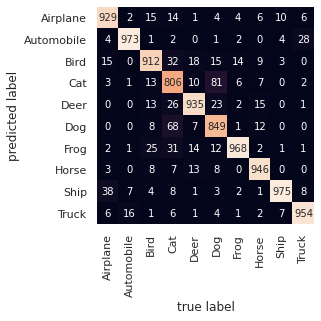

In [44]:
ytest=y_test1.flatten()
mat = confusion_matrix(ytest, ypred)
plt.figure()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names,)
plt.xlabel('true label')
plt.ylabel('predicted label');

#%%
print(classification_report(ytest, ypred, target_names=class_names))
print('Micro-averaged precision (treat instances equally) = {:.2f}'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision (treat classes equally) = {:.2f}'
      .format(precision_score(ytest, ypred, average = 'macro')))